In [47]:
import polars as pl
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns

load_dotenv()

True

In [48]:
cfg = pl.Config()
cfg.set_tbl_rows(100)
cfg.set_fmt_str_lengths(200)

polars.config.Config

In [ ]:
uri = os.environ.get("DATABASE_URL")

In [50]:
# if false, will read existing parquet files
READ_DB = False

In [ ]:
if READ_DB:
    local_query = """
  -- Find trip_ids that stopped at BOTH Nostrand (248) AND Kingston (249)
  WITH local_trips AS (
      SELECT trip_id
      FROM stop_time
      WHERE stop_id IN (248, 249) -- Stopped at Nostrand or Kingston
      GROUP BY trip_id
      HAVING COUNT(DISTINCT stop_id) = 2 -- Ensure the trip stopped at *both*
  )
  -- Select the Franklin (239) and Utica (250) stops ONLY for those local trips
  SELECT st.trip_id,
      st.stop_id,
      st.arrival,
      st.departure,
      st.scheduled_track,
      st.actual_track,
      t.mta_id,
      t.created_at,
      t.updated_at,
      t.route_id
  FROM stop_time st
  JOIN trip t ON st.trip_id = t.id
  WHERE st.stop_id IN (239, 250) -- Select Franklin or Utica stops
    AND t.direction = 0
    AND t.assigned = True
    AND st.trip_id IN (SELECT trip_id FROM local_trips) -- Only include trips identified in the CTE
  """
    df_lcl = pl.read_database_uri(query=local_query, uri=uri)
    df_lcl.write_parquet(r"data/local_trips.parquet")
else:
    df_lcl = pl.read_parquet(r"data/local_trips.parquet")

In [ ]:
if READ_DB:
    express_query = """
  WITH
    -- Trips that stopped at BOTH Franklin (239) AND Utica (250)
    trips_at_239_250 AS (
      SELECT trip_id
      FROM stop_time
      WHERE stop_id IN (239, 250)
      GROUP BY trip_id
      HAVING COUNT(DISTINCT stop_id) = 2
    ),
    -- Trips that stopped at EITHER Nostrand (248) OR Kingston (249)
    trips_at_248_or_249 AS (
      SELECT DISTINCT trip_id
      FROM stop_time
      WHERE stop_id IN (248, 249)
    )
  -- Select Franklin (239) and Utica (250) stops for trips that
  -- stopped at 239 AND 250, but NOT at 248 OR 249.
  SELECT
    st.trip_id,
    st.stop_id,
    st.arrival,
    st.departure,
    st.scheduled_track,
    st.actual_track,
    t.mta_id,
    t.created_at,
    t.updated_at,
    t.route_id
  FROM stop_time st
  JOIN trip t ON st.trip_id = t.id
  WHERE
    st.stop_id IN (239, 250)       -- Only get the rows for these stops
    AND t.direction = 0
    AND t.assigned = True
    AND st.trip_id IN (SELECT trip_id FROM trips_at_239_250) -- Must have stopped at both 239 & 250
    AND st.trip_id NOT IN (SELECT trip_id FROM trips_at_248_or_249) -- Must NOT have stopped at 248 or 249
  """
    df_exp = pl.read_database_uri(query=express_query, uri=uri)
    df_exp.write_parquet(r"data/express_trips.parquet")
else:
    df_exp = pl.read_parquet(r"data/express_trips.parquet")

In [54]:
df_exp = df_exp.sort(by=["trip_id", "stop_id"])
df_lcl = df_lcl.sort(by=["trip_id", "stop_id"])

In [55]:
# convert from UTC to EST
df_exp = df_exp.with_columns(
    arrival=pl.col("arrival").dt.convert_time_zone("America/New_York"),
    departure=pl.col("departure").dt.convert_time_zone("America/New_York"),
)
df_lcl = df_lcl.with_columns(
    arrival=pl.col("arrival").dt.convert_time_zone("America/New_York"),
    departure=pl.col("departure").dt.convert_time_zone("America/New_York"),
)

In [ ]:
# These trips stopped at 239, 250, 248, AND 249 based on the SQL query
local_stops = df_lcl.select(["trip_id", "stop_id", "arrival"]).pivot(
    index="trip_id", on="stop_id", values="arrival"
)
# Rename columns for clarity
local_stops = local_stops.rename({"239": "arrival_239", "250": "arrival_250"})
# Filter trips that stop at both stations (should be guaranteed by query, but good practice)
local_stops = local_stops.filter(
    pl.col("arrival_239").is_not_null() & pl.col("arrival_250").is_not_null()
)
# Rename columns for join and sort by arrival at Franklin
local_trips_pivoted = local_stops.rename(
    {
        "trip_id": "trip_id_local",  # Renamed to avoid confusion if route_id isn't 3
        "arrival_239": "arrival_local_239",
        "arrival_250": "arrival_local_250",
    }
).sort("arrival_local_239")


# --- Pivot Express Trips (df_exp) ---
# These trips stopped at 239, 250 but NOT 248 or 249 based on the SQL query
express_stops = df_exp.select(["trip_id", "stop_id", "arrival"]).pivot(
    index="trip_id", on="stop_id", values="arrival"
)
# Rename columns for clarity
express_stops = express_stops.rename({"239": "arrival_239", "250": "arrival_250"})
# Filter trips that stop at both stations (should be guaranteed by query)
express_stops = express_stops.filter(
    pl.col("arrival_239").is_not_null() & pl.col("arrival_250").is_not_null()
)
# Rename columns for join and sort by arrival at Franklin
express_trips_pivoted = express_stops.rename(
    {
        "trip_id": "trip_id_express",  # Renamed to avoid confusion if route_id isn't 4
        "arrival_239": "arrival_express_239",
        "arrival_250": "arrival_express_250",
    }
).sort("arrival_express_239")


# --- Use join_asof ---
# For each express-pattern trip, find the *next* local-pattern trip
# that arrives at Franklin (239) strictly *after* the express trip but within 15 minutes.
paired_trips = express_trips_pivoted.join_asof(
    local_trips_pivoted,
    left_on="arrival_express_239",  # Time on the left DF (express pattern trip)
    right_on="arrival_local_239",  # Time on the right DF (local pattern trip)
    strategy="forward",  # Find the first local train *after* or at the express train time
    tolerance="15m",  # Match if arrival_local_239 is within 15 mins *after* arrival_express_239
)

In [ ]:
result = (
    paired_trips.filter(
        pl.col("trip_id_local").is_not_null()  # A match was found within tolerance
        & (
            pl.col("arrival_local_239") > pl.col("arrival_express_239")
        )  # Strictly after at Franklin
        & (
            pl.col("arrival_local_250") < pl.col("arrival_express_250")
        )  # Local train arrives earlier at Utica
    )
    .with_columns(
        [
            # Time difference at Franklin (Local arrival - Express arrival) -> should be 0 < diff <= 15 mins (based on tolerance)
            (
                (
                    pl.col("arrival_local_239") - pl.col("arrival_express_239")
                ).dt.total_seconds()
                / 60
            ).alias("time_diff_239_min"),
            # Time difference at Utica (Express arrival - Local arrival) -> positive means local won
            (
                (
                    pl.col("arrival_express_250") - pl.col("arrival_local_250")
                ).dt.total_seconds()
                / 60
            ).alias("time_diff_250_min"),
        ]
    )
    .sort(
        "arrival_express_239"
    )  # Sort chronologically by the express train's arrival at Franklin
)

In [69]:
# Join route_id to the result
result = result.join(
    df_exp.select(["trip_id", "route_id"]).rename(
        {"trip_id": "trip_id_express", "route_id": "route_id_express"}
    ),
    on="trip_id_express",
    how="inner",
).join(
    df_lcl.select(["trip_id", "route_id"]).rename(
        {"trip_id": "trip_id_local", "route_id": "route_id_local"}
    ),
    on="trip_id_local",
    how="inner",
)


In [ ]:
# Numerator: Number of successful "overtake" events (rows in the final result)
overtake_events = result.height

# Denominator: Total number of pairs where a local arrived 0-15 mins after an express at Franklin
# We need to filter paired_trips based on the conditions *before* the Utica arrival check
total_potential_pairs = paired_trips.filter(
    pl.col(
        "trip_id_local"
    ).is_not_null()  # Ensure a local train was found within tolerance
    & (
        pl.col("arrival_local_239") > pl.col("arrival_express_239")
    )  # Local arrived strictly after express at Franklin
).height

# Calculate the empirical probability
if total_potential_pairs > 0:
    p_hat_A = overtake_events / total_potential_pairs
    print(
        f"Total potential pairs (Local arrived 0-15 min after Express at Franklin): {total_potential_pairs}"
    )
    print(
        f"Successful overtake events (Local arrived before Express at Utica): {overtake_events}"
    )
    print(f"Empirical Probability P_hat(A): {p_hat_A:.4f}")
else:
    print("No potential pairs found to calculate probability.")


Total potential pairs (Local arrived 0-15 min after Express at Franklin): 5085
Successful overtake events (Local arrived before Express at Utica): 1176
Empirical Probability P_hat(A): 0.2313


In [77]:
result.sort("arrival_express_250", descending=True).with_columns(
    ts=(
        pl.col("arrival_express_250").dt.offset_by("-30m").dt.timestamp("ms") / 1000
    ).cast(pl.Int64)  # add unix timestamp which frontend uses to set time
)

trip_id_express,arrival_express_239,arrival_express_250,trip_id_local,arrival_local_239,arrival_local_250,time_diff_239_min,time_diff_250_min,route_id_express,route_id_local,ts
str,"datetime[μs, America/New_York]","datetime[μs, America/New_York]",str,"datetime[μs, America/New_York]","datetime[μs, America/New_York]",f64,f64,str,str,i64
"""01966a2a-f781-7671-bea7-d296b9b33f8f""",2025-04-24 21:05:26 EDT,2025-04-24 21:15:41 EDT,"""01966a2e-c939-7892-bf32-fafb19fde70f""",2025-04-24 21:07:17 EDT,2025-04-24 21:13:48 EDT,1.85,1.883333,"""4""","""3""",1745541941
"""01966a2a-f781-7671-bea7-d296b9b33f8f""",2025-04-24 21:05:26 EDT,2025-04-24 21:15:41 EDT,"""01966a2e-c939-7892-bf32-fafb19fde70f""",2025-04-24 21:07:17 EDT,2025-04-24 21:13:48 EDT,1.85,1.883333,"""4""","""3""",1745541941
"""01966a2a-f781-7671-bea7-d296b9b33f8f""",2025-04-24 21:05:26 EDT,2025-04-24 21:15:41 EDT,"""01966a2e-c939-7892-bf32-fafb19fde70f""",2025-04-24 21:07:17 EDT,2025-04-24 21:13:48 EDT,1.85,1.883333,"""4""","""3""",1745541941
"""01966a2a-f781-7671-bea7-d296b9b33f8f""",2025-04-24 21:05:26 EDT,2025-04-24 21:15:41 EDT,"""01966a2e-c939-7892-bf32-fafb19fde70f""",2025-04-24 21:07:17 EDT,2025-04-24 21:13:48 EDT,1.85,1.883333,"""4""","""3""",1745541941
"""01966a06-af7d-7670-9ffb-0c70efe8bcb7""",2025-04-24 20:26:06 EDT,2025-04-24 20:36:37 EDT,"""01966a0b-0364-7d03-9c52-cac1cbf5866e""",2025-04-24 20:27:13 EDT,2025-04-24 20:33:35 EDT,1.116667,3.033333,"""4""","""3""",1745539597
"""01966a06-af7d-7670-9ffb-0c70efe8bcb7""",2025-04-24 20:26:06 EDT,2025-04-24 20:36:37 EDT,"""01966a0b-0364-7d03-9c52-cac1cbf5866e""",2025-04-24 20:27:13 EDT,2025-04-24 20:33:35 EDT,1.116667,3.033333,"""4""","""3""",1745539597
"""01966a06-af7d-7670-9ffb-0c70efe8bcb7""",2025-04-24 20:26:06 EDT,2025-04-24 20:36:37 EDT,"""01966a0b-0364-7d03-9c52-cac1cbf5866e""",2025-04-24 20:27:13 EDT,2025-04-24 20:33:35 EDT,1.116667,3.033333,"""4""","""3""",1745539597
"""01966a06-af7d-7670-9ffb-0c70efe8bcb7""",2025-04-24 20:26:06 EDT,2025-04-24 20:36:37 EDT,"""01966a0b-0364-7d03-9c52-cac1cbf5866e""",2025-04-24 20:27:13 EDT,2025-04-24 20:33:35 EDT,1.116667,3.033333,"""4""","""3""",1745539597
"""019667b1-f0f8-7642-bf43-65ce6f7eebc9""",2025-04-24 09:48:24 EDT,2025-04-24 09:57:06 EDT,"""0196679f-72ca-7522-ae3a-6634807ddb3b""",2025-04-24 09:48:43 EDT,2025-04-24 09:55:15 EDT,0.316667,1.85,"""4""","""2""",1745501226


## Event Space

- All trains stopping at Franklin and Utica.

## Events we are looking for:

- A local train arriving after the express train at Franklin (stop ID 239) but before that express train at Utica Ave (stop ID 250)


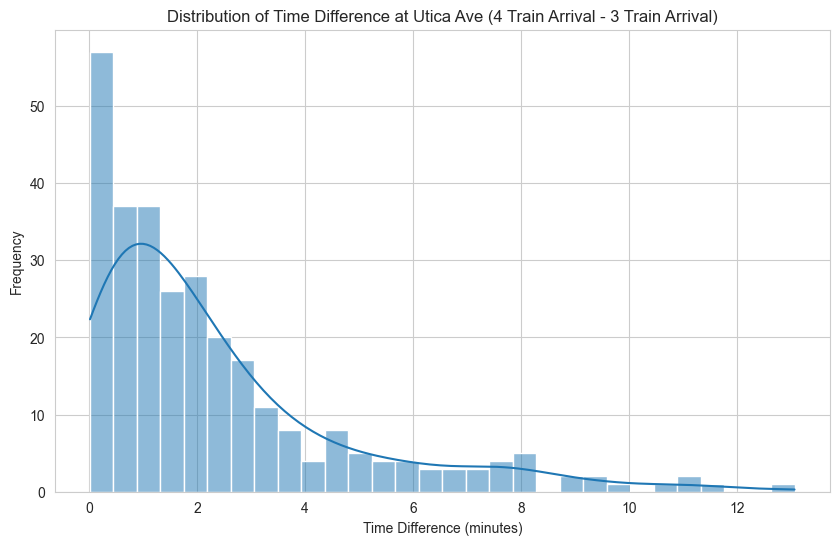

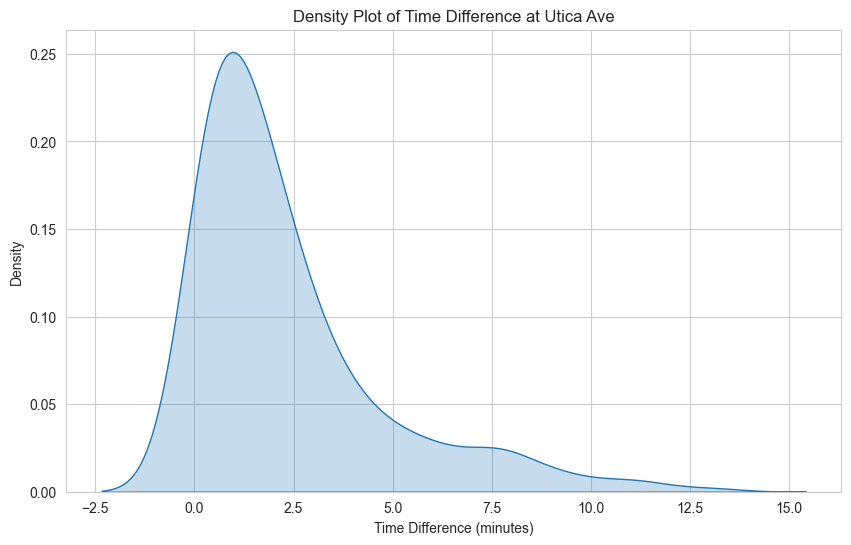

Descriptive Statistics for time_diff_250_min:
shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 294.0     │
│ null_count ┆ 0.0       │
│ mean       ┆ 2.353912  │
│ std        ┆ 2.449474  │
│ min        ┆ 0.016667  │
│ 25%        ┆ 0.65      │
│ 50%        ┆ 1.55      │
│ 75%        ┆ 2.983333  │
│ max        ┆ 13.066667 │
└────────────┴───────────┘


In [60]:
sns.set_style("whitegrid")

# 1. Histogram
plt.figure(figsize=(10, 6))
sns.histplot(
    data=result, x="time_diff_250_min", bins=30, kde=True
)  # kde=True adds a density curve
plt.title(
    "Distribution of Time Difference at Utica Ave (4 Train Arrival - 3 Train Arrival)"
)
plt.xlabel("Time Difference (minutes)")
plt.ylabel("Frequency")
plt.show()

# 2. Box Plot (useful if you later group by time of day, etc.)
# plt.figure(figsize=(8, 4))
# sns.boxplot(data=result, x="time_diff_250_min")
# plt.title("Box Plot of Time Difference at Utica Ave")
# plt.xlabel("Time Difference (minutes)")
# plt.show()

# 3. Density Plot (Smoother version of histogram)
plt.figure(figsize=(10, 6))
sns.kdeplot(data=result, x="time_diff_250_min", fill=True)
plt.title("Density Plot of Time Difference at Utica Ave")
plt.xlabel("Time Difference (minutes)")
plt.ylabel("Density")
plt.show()

# --- Basic Statistics ---
print("Descriptive Statistics for time_diff_250_min:")
print(result["time_diff_250_min"].describe())

In [ ]:
# result.filter(pl.col("time_diff_250_min") < 10).unique(["trip_id_3", "trip_id_4"])
# result.sort("time_diff_250_min", descending=True).head(500).tail(5)


trip_id_3,arrival_3_250,arrival_3_239,trip_id_4,arrival_4_250,arrival_4_239,time_diff_239_min,time_diff_250_min
str,"datetime[μs, America/New_York]","datetime[μs, America/New_York]",str,"datetime[μs, America/New_York]","datetime[μs, America/New_York]",f64,f64
"""0195a47d-564e-7182-9c9a-368954d7b558""",2025-03-17 10:45:45 EDT,2025-03-17 10:37:51 EDT,"""01966981-c825-7120-ae48-c2f831fe2253""",2025-04-24 18:16:29 EDT,2025-04-24 18:09:30 EDT,55171.65,55170.733333
"""0195a47d-564a-7911-989d-72dc09acf747""",2025-03-17 11:10:42 EDT,2025-03-17 11:04:07 EDT,"""0196699e-9773-70c1-90a0-53ce1d64a843""",2025-04-24 18:41:26 EDT,2025-04-24 18:37:52 EDT,55173.75,55170.733333
"""0195a47d-564c-7552-9a31-7fe99b51f204""",2025-03-17 11:38:57 EDT,2025-03-17 11:33:47 EDT,"""019669b6-7101-71b3-bcca-6559240dafb5""",2025-04-24 19:08:54 EDT,2025-04-24 19:05:37 EDT,55171.833333,55169.95
"""0195a4b1-fc37-72d2-ab55-6687d53dbca7""",2025-03-17 12:57:00 EDT,2025-03-17 12:50:30 EDT,"""019669fc-f0db-73f3-9ca1-16c0bf9b534c""",2025-04-24 20:26:51 EDT,2025-04-24 20:22:51 EDT,55172.35,55169.85
"""0195a49f-8b35-7283-a8af-1778282a2de7""",2025-03-17 12:31:18 EDT,2025-03-17 12:25:41 EDT,"""019669ec-2641-7872-bac7-5a6730c89cb7""",2025-04-24 20:01:01 EDT,2025-04-24 19:56:41 EDT,55171.0,55169.716667
